# **Import Library**

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter
import re
import string

In [30]:
pip install imbalanced-learn

# **Memuat Dataset**

In [31]:
df = pd.read_csv('/content/Reviews_Shopee.csv')

print("Jumlah baris dan kolom:")
print(df.shape)

print("\nInformasi kolom:")
print(df.info())

print("\n5 baris pertama dataset:")
print(df.head())


Jumlah baris dan kolom:
(7993, 11)

Informasi kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7993 entries, 0 to 7992
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              7993 non-null   object 
 1   userName              7993 non-null   object 
 2   userImage             7993 non-null   object 
 3   content               7993 non-null   object 
 4   score                 7992 non-null   float64
 5   thumbsUpCount         7992 non-null   float64
 6   reviewCreatedVersion  7923 non-null   object 
 7   at                    7992 non-null   object 
 8   replyContent          7410 non-null   object 
 9   repliedAt             7410 non-null   object 
 10  appVersion            7923 non-null   object 
dtypes: float64(2), object(9)
memory usage: 687.0+ KB
None

5 baris pertama dataset:
                               reviewId         userName  \
0  08875cd9-7c15-4849-981f-1e7a2

In [32]:
print("\nJumlah nilai yang hilang per kolom:")
print(df.isnull().sum())


Jumlah nilai yang hilang per kolom:
reviewId                  0
userName                  0
userImage                 0
content                   0
score                     1
thumbsUpCount             1
reviewCreatedVersion     70
at                        1
replyContent            583
repliedAt               583
appVersion               70
dtype: int64


In [33]:
print("\nDistribusi rating:")
print(df['score'].value_counts())


Distribusi rating:
score
5.0    7992
Name: count, dtype: int64


# **Data Preprocessing**

# Cek Data Missing

In [34]:
df_cleaned = df.dropna(subset=['userName'])
print(df_cleaned.isnull().sum())

reviewId                  0
userName                  0
userImage                 0
content                   0
score                     1
thumbsUpCount             1
reviewCreatedVersion     70
at                        1
replyContent            583
repliedAt               583
appVersion               70
dtype: int64


# Text Cleaning

In [35]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['cleaned_comment'] = df['content'].apply(clean_text)

# Labeling Sentimen

In [36]:
def get_sentiment(text):
    from textblob import TextBlob
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return 'positif'
    elif polarity < 0:
        return 'negatif'
    else:
        return 'netral'

df['label'] = df['cleaned_comment'].apply(get_sentiment)

# **Data Preparation**

In [37]:
y = LabelEncoder().fit_transform(df['label'])
X = df['cleaned_comment']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# **Eksperimen Dengan 3 Skema Pelatihan**

## **Skema 1: SVM dengan TF-IDF(80/20 split)**

In [38]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train_raw)
X_test_tfidf = vectorizer.transform(X_test_raw)

smote = SMOTE(random_state=42)
X_train_tfidf_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

print("Distribusi label setelah SMOTE:", Counter(y_train_smote))

Distribusi label setelah SMOTE: Counter({np.int64(1): 5642, np.int64(2): 5642, np.int64(0): 5642})


In [39]:
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_tfidf_smote, y_train_smote)
y_pred_svm = svm.predict(X_test_tfidf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("\nEvaluasi Model SVM:")
print(f"Accuracy: {accuracy_svm}")
print(classification_report(y_test, y_pred_svm, target_names=['negatif', 'netral', 'positif']))


Evaluasi Model SVM:
Accuracy: 0.975609756097561
              precision    recall  f1-score   support

     negatif       1.00      0.40      0.57        15
      netral       0.98      1.00      0.99      1411
     positif       0.96      0.86      0.91       173

    accuracy                           0.98      1599
   macro avg       0.98      0.75      0.82      1599
weighted avg       0.98      0.98      0.97      1599



## **Skema 2: Random Forest dengan Word2Vec (80/20 split)**

In [40]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tfidf_smote, y_train_smote)
y_pred_rf = rf.predict(X_test_tfidf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("\nEvaluasi Model Random Forest:")
print(f"Accuracy: {accuracy_rf}")
print(classification_report(y_test, y_pred_rf, target_names=['negatif', 'netral', 'positif']))


Evaluasi Model Random Forest:
Accuracy: 0.9143214509068167
              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00        15
      netral       0.91      1.00      0.95      1411
     positif       0.95      0.31      0.47       173

    accuracy                           0.91      1599
   macro avg       0.62      0.44      0.47      1599
weighted avg       0.91      0.91      0.89      1599



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **Skema 3: Deep Learning LSTM (70/30 split)**

In [41]:
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_raw)

X_train_seq = tokenizer.texts_to_sequences(X_train_raw)
X_test_seq = tokenizer.texts_to_sequences(X_test_raw)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

y_train_cat = pd.get_dummies(y_train).values
y_test_cat = pd.get_dummies(y_test).values

In [42]:
model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=100, input_length=max_len),
    LSTM(128, return_sequences=True, kernel_regularizer='l2'),
    Dropout(0.5),
    LSTM(64, kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

history = model_lstm.fit(
    X_train_pad, y_train_cat,
    epochs=15,
    batch_size=64,
    validation_data=(X_test_pad, y_test_cat),
    callbacks=callbacks
)

loss, accuracy_lstm = model_lstm.evaluate(X_test_pad, y_test_cat)
print("\nEvaluasi Model LSTM:")
print(f"Accuracy: {accuracy_lstm}")


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 398ms/step - accuracy: 0.8495 - loss: 2.5171 - val_accuracy: 0.8824 - val_loss: 0.5955 - learning_rate: 0.0010
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 418ms/step - accuracy: 0.8793 - loss: 0.5420 - val_accuracy: 0.8824 - val_loss: 0.4196 - learning_rate: 0.0010
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 388ms/step - accuracy: 0.8858 - loss: 0.4108 - val_accuracy: 0.8824 - val_loss: 0.4132 - learning_rate: 0.0010
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 389ms/step - accuracy: 0.8788 - loss: 0.4244 - val_accuracy: 0.8824 - val_loss: 0.3984 - learning_rate: 0.0010
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 402ms/step - accuracy: 0.8900 - loss: 0.3850 - val_accuracy: 0.8824 - val_loss: 0.3978 - learning_rate: 0.0010
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 402ms/step - accuracy: 0.8806 - loss: 0.4125 - val_accuracy: 0.8824 - val_loss: 0.3963 - learning_rate: 0.0010
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 399ms/step - accuracy: 0.8834 - loss:

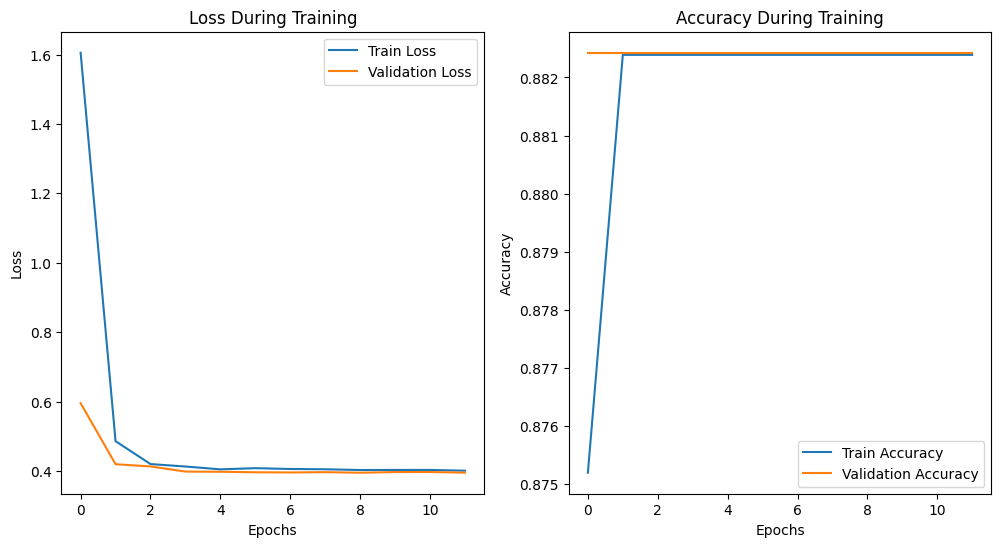

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **Testing**

In [44]:
accuracies = {'SVM': accuracy_svm, 'Random Forest': accuracy_rf, 'LSTM': accuracy_lstm}

best_model_name = max(accuracies, key=accuracies.get)
print("\nModel terbaik berdasarkan akurasi:", best_model_name)


Model terbaik berdasarkan akurasi: SVM


In [45]:
le = LabelEncoder()
le.fit(df['label'])
if best_model_name == 'SVM':
    best_model = svm
    best_predictions = y_pred_svm
elif best_model_name == 'Random Forest':
    best_model = rf
    best_predictions = y_pred_rf
else:
    best_model = model_lstm
    best_predictions = model_lstm.predict(X_test_pad).argmax(axis=1)

comparison_df = pd.DataFrame({
    'Actual': le.inverse_transform(y_test),
    'Predicted': le.inverse_transform(best_predictions)
})
print("\nPerbandingan Label Asli dan Prediksi dengan Model Terbaik:")
print(comparison_df.head())


Perbandingan Label Asli dan Prediksi dengan Model Terbaik:
   Actual Predicted
0  netral    netral
1  netral    netral
2  netral    netral
3  netral    netral
4  netral    netral


In [47]:
!pip freeze > requirements.txt

df = pd.read_csv('requirements.txt', names=['Package'])
df.to_csv('requirements.csv', index=False)